In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [3]:
d19 = pd.read_csv(r"C:\Users\Njula Chakaya\OneDrive\Documents\Masters_Practicals\Collaborative App Devt\Data Files\D19.csv", header = 1)

d19.head()

,BookingReference,Created Date,Reference,Attendee Status,Attended
0,B739461,16/07/2019,A802512,Cancelled,NaN
1,B739462,16/07/2019,A802513,Attending,Yes
2,B739463,16/07/2019,A802514,Attending,Yes
3,B739464,16/07/2019,A802515,Attending,No
4,B739465,16/07/2019,A802516,Attending,No


In [28]:
d19.shape

(1185, 7)

In [4]:
# Aggregate the data on a weekly basis
d19["Created Date"] = pd.to_datetime(d19["Created Date"], format='%d/%m/%Y')

d19['Week'] = d19['Created Date'].dt.isocalendar().week # uses ISO calendar week starts on Monday
d19['Year'] = d19['Created Date'].dt.year
weekly_reg = d19.groupby(['Year','Week']).size()

#convert to dataframe
weekly_reg = weekly_reg.reset_index()
weekly_reg.columns = ['Year','Week', 'Total Registrations']

"""
Note that the ISO calendar uses the actual week so in this case, the date 16th July 2019 fell on week 29 of that year.

"""

'\nNote that the ISO calendar uses the actual week so in this case, the date 16th July 2019 fell on week 29 of that year.\n\n'

In [5]:
weekly_reg

,Year,Week,Total Registrations
0,2019,29,125
1,2019,31,141
2,2019,32,35
3,2019,33,15
4,2019,34,8
5,2019,35,12
6,2019,36,26
7,2019,37,16
8,2019,38,16
9,2019,39,31


In [6]:
# Calculate the Z score for the Total Registrations
weekly_reg['Z-Score'] = (weekly_reg['Total Registrations'] - weekly_reg['Total Registrations'].mean())/ weekly_reg['Total Registrations'].std()

# Binary indicator for weeks that have a Z-score greater than 1
weekly_reg['Advertisement'] = (weekly_reg['Z-Score'] > 1).astype(int)

In [7]:
weekly_reg

,Year,Week,Total Registrations,Z-Score,Advertisement
0,2019,29,125,0.921582,0
1,2019,31,141,1.170798,1
2,2019,32,35,-0.480261,0
3,2019,33,15,-0.791782,0
4,2019,34,8,-0.900814,0
5,2019,35,12,-0.838510,0
6,2019,36,26,-0.620445,0
7,2019,37,16,-0.776206,0
8,2019,38,16,-0.776206,0
9,2019,39,31,-0.542565,0


In [8]:
# Identifying weeks with missing data

# Find the first and last date in the 'Created Date' column
first_date = d19['Created Date'].min()
last_date = d19['Created Date'].max()

# Find the Monday of the week for the first date
start_of_first_week = first_date - pd.Timedelta(days=first_date.weekday())

# Find the end of the week for the last date (assuming weeks start on Monday)
end_of_last_week = last_date + pd.Timedelta(days=(6-last_date.weekday()))

complete = pd.DataFrame(pd.date_range(start=start_of_first_week, end=end_of_last_week, freq='W-MON').isocalendar().week)
complete['Year'] = pd.date_range(start=start_of_first_week, end=end_of_last_week, freq='W-MON').isocalendar().year

complete.columns = ['Week','Year']

complete_reg = pd.merge(complete, weekly_reg, on = ['Year','Week'], how = 'left')

# Replace NaN with 0
complete_reg['Total Registrations'].fillna(0, inplace = True)
complete_reg['Z-Score'].fillna(0, inplace = True)
complete_reg['Advertisement'].fillna(0, inplace = True)

In [9]:
complete_reg

,Week,Year,Total Registrations,Z-Score,Advertisement
0,29,2019,125.0,0.921582,0.0
1,30,2019,0.0,0.000000,0.0
2,31,2019,141.0,1.170798,1.0
3,32,2019,35.0,-0.480261,0.0
4,33,2019,15.0,-0.791782,0.0
5,34,2019,8.0,-0.900814,0.0
6,35,2019,12.0,-0.838510,0.0
7,36,2019,26.0,-0.620445,0.0
8,37,2019,16.0,-0.776206,0.0
9,38,2019,16.0,-0.776206,0.0


In [10]:
# Create table with date time index
#weekly_reg['Date'] = pd.to_datetime(weekly_reg['Year'].astype(str) + 'W' + weekly_reg['Week'].astype(str) + '1', format='%GW%V%u')

#data_model = weekly_reg.set_index('Date')[['Total Registrations', 'Advertisement']]

# Assuming 'weekly_reg' contains the 'Year' and 'Week' columns
weekly_reg['Date'] = pd.to_datetime(weekly_reg['Year'].astype(str) + '-' + weekly_reg['Week'].astype(str) + '-1', format='%G-%V-%u')

# Now set the 'Date' column as the datetime index
data_model = weekly_reg.set_index('Date')[['Total Registrations', 'Advertisement']]


In [11]:
data_model

,Total Registrations,Advertisement
Date,,
2019-07-15,125,0
2019-07-29,141,1
2019-08-05,35,0
2019-08-12,15,0
2019-08-19,8,0
2019-08-26,12,0
2019-09-02,26,0
2019-09-09,16,0
2019-09-16,16,0


In [12]:
# Buliding the SARIMAX model

#Split the data into train and test sets
split = int(len(data_model) * 0.8) # 80/20 split
train = data_model.iloc[:split]
test = data_model.iloc[split:]

In [13]:
# Selecting model parameters with auto arima
#auto = auto_arima(train['Total Registrations'], exogenous = train[['Advertisement']], seasonal = True, m = 15,max_D = 1, stepwise = True, trace = True)

#print(auto.summary())

In [14]:
# The model
model = SARIMAX(train['Total Registrations'],
                exog = train[['Advertisement']],
                order = (1,0,1),
                seasonal_order = (0,0,0,0),
                enforce_stationarity = False,
                enforce_invertibility = False)

fitted = model.fit()

# Forecasting
ex_variable = test[['Advertisement']]
forecast = fitted.get_forecast(steps = len(test), exog = ex_variable)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int() 

# Evaluation
rmse = np.sqrt(mean_squared_error(test['Total Registrations'], forecast_values))
print(f"RMSE: {rmse}")

RMSE: 103.65784087977164


c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Njula Chakaya\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No suppo

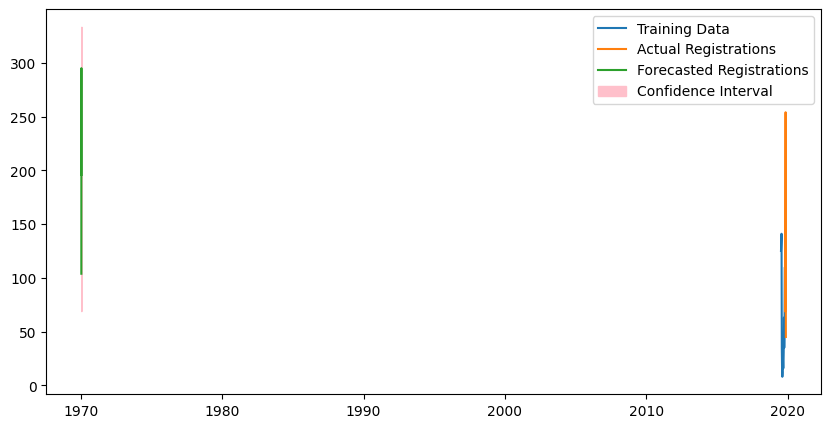

In [15]:
# Plot the forecast along with the confidence band
plt.figure(figsize=(10, 5))
plt.plot(train['Total Registrations'], label='Training Data')
plt.plot(test['Total Registrations'], label='Actual Registrations')
plt.plot(forecast_values, label='Forecasted Registrations')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', label='Confidence Interval')
plt.legend()
plt.show()


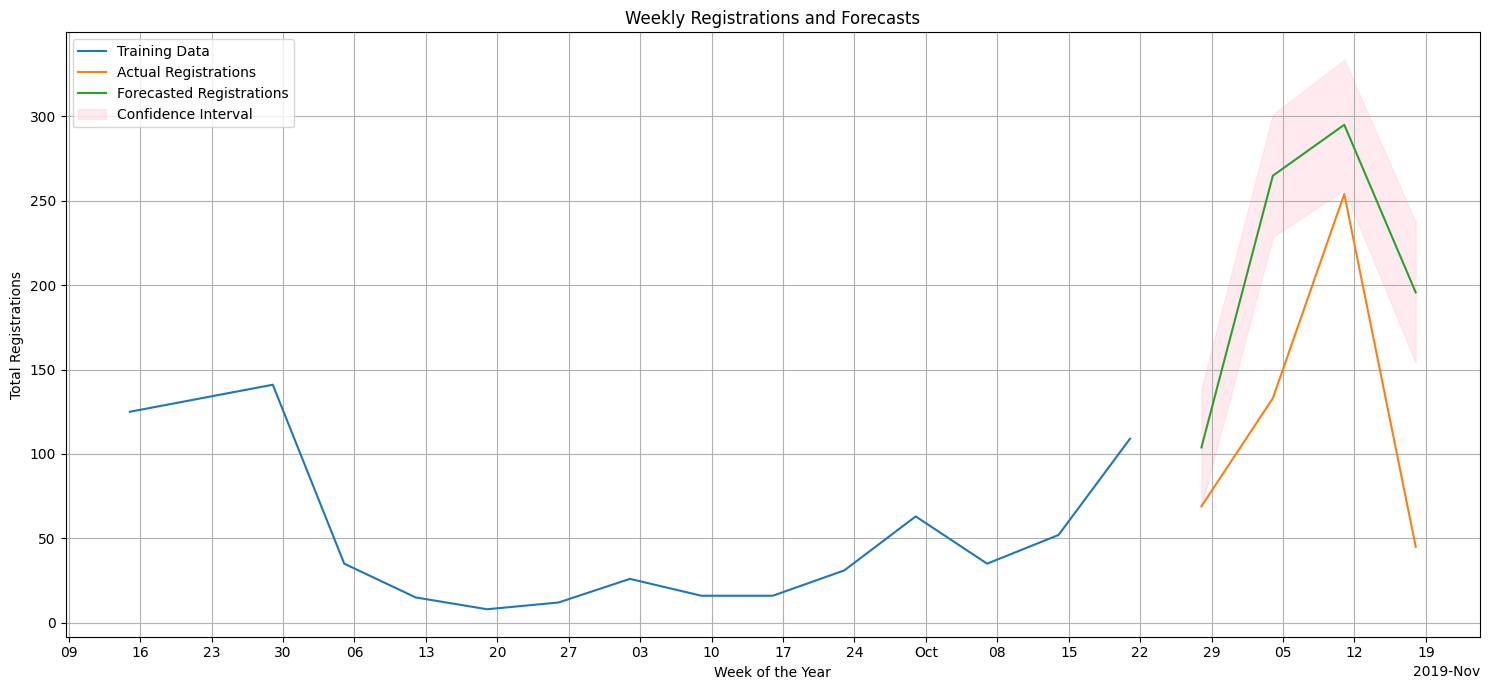

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming 'train', 'test', 'forecast_values', and 'conf_int' are already defined and have a weekly datetime index

plt.figure(figsize=(15, 7))
plt.plot(train.index, train['Total Registrations'], label='Training Data')
plt.plot(test.index, test['Total Registrations'], label='Actual Registrations')
plt.plot(test.index, forecast_values, label='Forecasted Registrations')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Interval')

# Set the locator for the x-axis to show every week
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.WeekdayLocator()))

plt.title('Weekly Registrations and Forecasts')
plt.xlabel('Week of the Year')
plt.ylabel('Total Registrations')
plt.legend()
plt.grid(visible=True)
plt.tight_layout()
plt.show()


In [22]:
# Train on daily data
#daily_reg = d19.groupby(['Created Date']).size()

daily_reg = d19.groupby('Created Date').size().reset_index(name='Total Registrations')

In [26]:
first_date = d19['Created Date'].min()
last_date = d19['Created Date'].max()

date_range = pd.DataFrame(pd.date_range(start=first_date, end=last_date), columns=['Date'])

complete_reg = pd.merge(date_range, daily_reg, left_on='Date', right_on='Created Date', how='left')

complete_reg.drop(columns=['Created Date'], inplace=True)

complete_reg['Total Registrations'].fillna(0, inplace=True)

In [27]:
complete_reg

,Date,Total Registrations
0,2019-07-16,125.0
1,2019-07-17,0.0
2,2019-07-18,0.0
3,2019-07-19,0.0
4,2019-07-20,0.0
...,...,...
121,2019-11-14,22.0
122,2019-11-15,45.0
123,2019-11-16,0.0
124,2019-11-17,0.0
